# Graph Kernels

In this notebook we provide examples of how tilings constructed with the graph kernels of the GR family (GRG and GRGS) can be used in practice

In [1]:
from hypertiling import HyperbolicGraph, GraphKernels
from hypertiling.graphics.plot import plot_tiling
from hypertiling.kernel.GRG_util import plot_graph
import matplotlib.pyplot as plt

#define colors
palette = ["#81b29a", "#f2cc8f", "#e07a5f"]

## Exploring GRG and GRGS

In [2]:
# Use GRG kernel to construct tiling
G = HyperbolicGraph(3, 7, 5, kernel = "GRG")

Use graph plot functions that comes with GRG


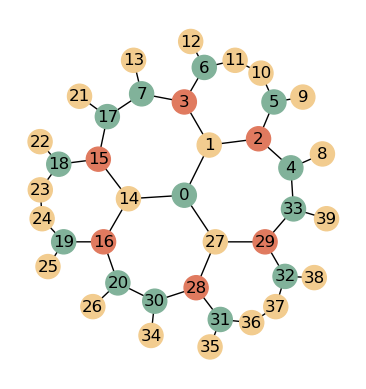

In [3]:
nbrs = G.get_nbrs_list()  # get neighbors
crds = G.center_coords    # get coordinates of cell centers
p = G.p                   # lattice parameter p

# color nodes by layer
colors = [palette[G.get_reflection_level(i) % len(palette)] for i in range(G.length)]

plot_graph(nbrs, crds, p, colors)

plt.gca().set_aspect('equal')
plt.axis("off")
plt.show()

We can create the same lattice with GRGS, the static variant of GRG. Here, every cell is explicitely created

In [4]:
# Use GRGS kernel to construct tiling
G = HyperbolicGraph(3, 7, 5, kernel = "GRGS") 

And again, we plot the corresponding graph. Note the different order of indices compared to the above plot!

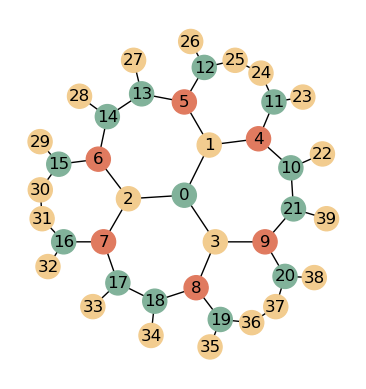

In [5]:
nbrs = G.get_nbrs_list()  # get neighbors
crds = G.center_coords    # get coordinates of cell centers
p = G.p                   # lattice parameter p

# color nodes by layer
colors = [palette[G.get_reflection_level(i) % len(palette)] for i in range(G.length)]

plot_graph(nbrs, crds, p, colors)

plt.gca().set_aspect('equal')
plt.axis("off")
plt.show()

As can be seen, the static variant has radially ordered indices as the whole tiling is constructed. The generative variant has radial ordered indices within a slice but globally slicewise ordered indices as only one sector is generated. 

## Application and Benchmark

In this simple statistic model, cells will always take on the color of the majority of their adjacent cells. As this does not depend on their position (only their neighboring relations, a graph instead of a tiling can be used, too). To highlight the advantages of GRG and GRGS we add some boundary condition. Namely, we want the most outer region to be in a certain state (1) at the start. As the plot function always plots the index too, the plotting itself is a bit slower than for the GR kernel. Therefore, we restrict this example to smaller tilings. 

In [6]:
from hypertiling import HyperbolicGraph, GraphKernels
from hypertiling.graphics.plot import plot_tiling
from hypertiling.kernel.GRG_util import plot_graph

import random
import time
import matplotlib.pyplot as plt
import numpy as np

### Generative Case

In [7]:
nlayers = 15

The usage of the generative kernel (GRG) has two clear advantages, namely smaller memory footprint and faster construction times

In [8]:
t1 = time.time()

G = HyperbolicGraph(7, 3, nlayers, kernel="GRG") 

print(f"Generation of {len(G)} polygons took {round(time.time() - t1,5)} s")

# Initialize voter model with random states
states = np.random.randint(0, 2, size=len(G))

# Set boundary conditions 
# this is a bit more complicated for generative graphs and radial boundary conditions
jump = G._nbrs.shape[0] - 1  # get length of sector
shift = G._sector_lengths_cumulated[-2]  # get start index in first sector

# iterate over all sectors
for i in range(p):  
    start = i * jump + shift
    states[start: start + G._sector_lengths[-1]] = 1

Generation of 3599597 polygons took 2.70119 s


Run the model and display resulting configuration

In [9]:
its = 1e5 # number of iterations

t1 = time.time()
for i in range(int(its)):
    index = int(len(G) * np.random.random())
    sum_ = sum([states[nbr] for nbr in G[index]])
    if sum_ > p // 2:
        states[index] = 1
    else:
        states[index] = 0
print(f"Running the model took {time.time() - t1}s")

Running the model took 6.590404272079468s


### Static case

The advantage of the static case is an increased speed for accessing the neighbors. However its disadvantages are a bigger memory requierement as well as a increased construction time.

In [10]:
t1 = time.time()

G = HyperbolicGraph(7, 3, nlayers, kernel="GRGS") 

print(f"Generation of {len(G)} polygons took {round(time.time() - t1,5)} s")

# Initialize voter model with random states
states = np.random.randint(0, 2, size=len(G))

# Set boundary conditions 
# this is simpler compared to the above examples
states[G._sector_lengths_cumulated[-2]:] = 1

Generation of 3599597 polygons took 18.83585 s


In [11]:
its = 1e5 # number of iterations

t1 = time.time()
for i in range(int(its)):
    index = int(len(G) * np.random.random())
    sum_ = sum([states[nbr] for nbr in G[index]])
    if sum_ > p // 2:
        states[index] = 1
    else:
        states[index] = 0
print(f"Running the model took {time.time() - t1}s")

Running the model took 2.9719417095184326s


As can be seen, the GRGS kernel is slower in constructing the tiling but faster in accessing the neighbors. We do not show the memory consumption explicitely. 

## Lattice Integrity

Similar to the GR kernel, GRG(S) kernels provide integrity check methods:

In [12]:
from hypertiling import HyperbolicGraph, GraphKernels
from hypertiling.graphics.plot import plot_tiling
from hypertiling.kernel.GRG_util import plot_graph
import matplotlib.pyplot as plt

#define colors
palette = ["#81b29a", "#f2cc8f", "#e07a5f"]

In [13]:
G = HyperbolicGraph(5, 4, 5, kernel = GraphKernels.GenerativeReflectionGraph)
G.check_integrity()

Integrity ensured till index 13. 13 has only 2 neighbors


This is the expected result. It can be explained by the fact, that the polygon with index 2 is the first polygon of the last layer and thus is missing some neighbors. We can either verify this pretty easily by accessing a protected attribute of GR (fastest and best method), by testing (more intuitive, still fast) or by plotting.

In [14]:
print(f"Expect complete set of neighbors until cell {G._sector_lengths_cumulated[-2]}")  

Expect complete set of neighbors until cell 13


For demonstration purposes, we access a protected attribute here, `_sector_lengths_cumulated`. If you dont know what protected means: dont touch it! It is an array that stores the start indices of each constructed as well as the next theoretical layer. Therefore, `t._sector_lengths_cumulated[-2]` accesses the first polygon of the last constructed layer.

In [15]:
print(G.get_reflection_level(12))

3


We can see, that the polygon with index 12 (= 13 - 1) is in the previous layer and thus the polygon with index is the first polygon in the layer with index 6 (layers start counting at 0 and thus in the 5th layer). Therefore, we expect it to miss some of its neighbors causing the message 

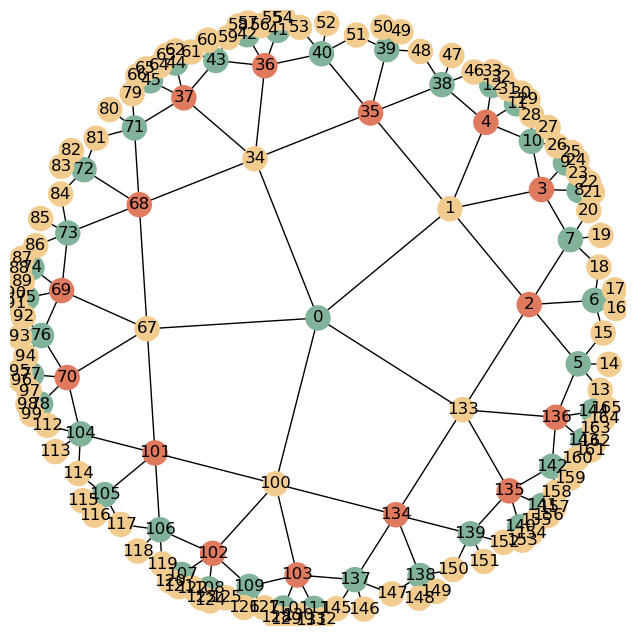

In [16]:
fig_ax = plt.subplots(figsize=(8,8))
fig_ax[1].set_xlim(-1, 1)
fig_ax[1].set_ylim(-1, 1)
fig_ax[1].set_box_aspect(1)

nbrs = G.get_nbrs_list()  # get neighbors
crds = G.center_coords    # get coordinates of cell centers
p = G.p                   # lattice parameter p

# color nodes by layer
colors = [palette[G.get_reflection_level(i) % len(palette)] for i in range(G.length)]

plot_graph(nbrs, crds, p, colors)

plt.gca().set_aspect('equal')
plt.axis("off")
plt.show()